Audio file formats:
1. .mp3 - lossy format
2. .flac - lossless format
3. .wav - uncompressed format

In [1]:
import wave

Audio signal paarmeters:
1. number of channels - Indicates the number of independent audio signals in the file
2. sample width - Determines the precision of each audio sample
3. framerate/sample rate - The number of samples taken per second
4. number of frames - The total number of audio samples in the file
5. values of  frame - The actual numerical data representing the amplitude of the audio signal at a specific point in time

Each sample in a frame corresponds to a specific point in the waveform of the audio signal.
The value of the sample represents the amplitude of the sound wave at that point, typically ranging from negative to positive values.
The collection of these values for all samples in a frame creates the audio waveform.

### Load wave file

In [89]:
obj = wave.open("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\harvard.wav", "rb")

In [90]:
obj

In [91]:
n_channels = obj.getnchannels()
sample_width = obj.getsampwidth()
sample_freq = obj.getframerate()
n_samples = obj.getnframes()

print("Number of channels ", n_channels)
print("Sample width ", sample_width)
print("Frame rate ", sample_freq)
print("Number of frames ", n_samples)
print("Parameters: ", obj.getparams())

Number of channels  2
Sample width  2
Frame rate  44100
Number of frames  809508
Parameters:  _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=809508, comptype='NONE', compname='not compressed')


In [92]:
## time duration of the audio
t_audio = n_samples / sample_freq
print(t_audio)

18.356190476190477


In [94]:
frames = obj.readframes(-1)
print(type(frames), type(frames[0]))
print(len(frames))

<class 'bytes'> <class 'int'>
3238032


In [93]:
print(type(frames))

<class 'bytes'>


### Creating new object and setting parameters

In [71]:
obj_new = wave.open("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\harvard_new.wav", "wb")

In [72]:
obj_new.setnchannels(1)
obj_new.setsampwidth(2)
obj_new.setframerate(16000.0)

In [73]:
obj_new.writeframes(frames)

In [74]:
obj_new.close

<bound method Wave_write.close of <wave.Wave_write object at 0x000001582D9D4190>>

### Plot the audio file

In [75]:
import wave
import matplotlib.pyplot as plt
import numpy as np

In [107]:
signal_wave = frames

In [108]:
len(signal_wave)

3238032

In [99]:
obj.close

<bound method Wave_read.close of <wave.Wave_read object at 0x00000158295E4090>>

In [100]:
print(type(signal_wave))

<class 'bytes'>


In [101]:
#converting signal array from bytes to numpy array
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
print(type(signal_array))

<class 'numpy.ndarray'>


In [102]:
len(signal_array)

1619016

In [103]:
times = np.linspace(0, t_audio, num=n_samples)

In [105]:
len(times)

809508

In [110]:
signal_array_subset = signal_array[:len(times)]

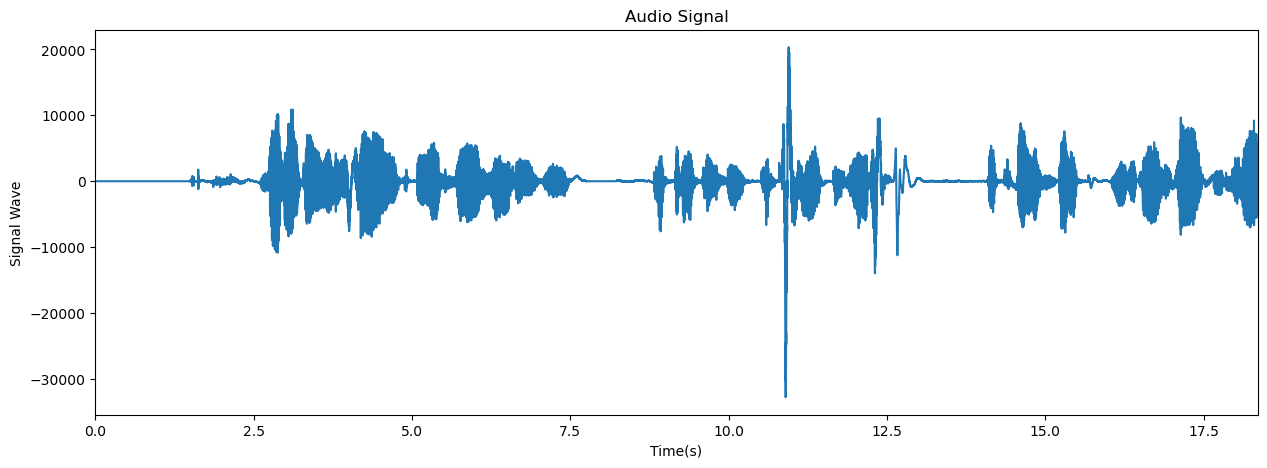

In [111]:
plt.figure(figsize=(15, 5))
plt.plot(times, signal_array_subset)
plt.title("Audio Signal")
plt.ylabel("Signal Wave")
plt.xlabel("Time(s)")
plt.xlim(0, t_audio)
plt.show()

### Record Mic

In [112]:
import pyaudio

In [113]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000

In [119]:
p = pyaudio.PyAudio()

stream = p.open(
    format = FORMAT,
    channels = CHANNELS,
    rate = RATE,
    input = True, 
    frames_per_buffer = FRAMES_PER_BUFFER 
)

print("start recording")

seconds = 5
frames = []
for i in range(0, int(RATE/FRAMES_PER_BUFFER*seconds)):
    data = stream.read(FRAMES_PER_BUFFER)
    frames.append(data)

stream.stop_stream()
stream.close()
p.terminate()

obj_rec = wave.open("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\recording.wav", "wb")
obj_rec.setnchannels(CHANNELS)
obj_rec.setsampwidth(p.get_sample_size(FORMAT))
obj_rec.setframerate(RATE)
obj_rec.writeframes(b"".join(frames))
obj_rec.close()

start recording


### Load mp3 files

In [4]:
from pydub import AudioSegment

audio = AudioSegment.from_wav("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\harvard.wav")
## .from_mp3 for mp3 files

## increase the volume by 6dB
audio = audio + 6

audio = audio * 2

audio = audio.fade_in(2000)

audio.export("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\mashup.mp3", format="mp3")

<_io.BufferedRandom name='C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\mashup.mp3'>

In [6]:
audio2 = AudioSegment.from_mp3("C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\mashup.mp3")
print("done")

done


### Converting speech to text

In [20]:
API_KEY_ASSEMBLYAI = "827987b5f53d47b0befc924a0a8f790d"

## upload file
import requests
import time
import sys

filename = "C:\\Users\\Parishri\\OneDrive\\Desktop\\Desktop\\Study stuff\\audio recognition\\harvard.wav"

upload_endpoint = 'https://api.assemblyai.com/v2/upload'

headers_auth_only = {'authorization': API_KEY_ASSEMBLYAI}

CHUNK_SIZE = 5_242_880  # 5MB

def upload(filename):
    def read_file(filename):
        with open(filename, 'rb') as f:
            while True:
                data = f.read(CHUNK_SIZE)
                if not data:
                    break
                yield data

    upload_response = requests.post(upload_endpoint, headers=headers_auth_only, data=read_file(filename))
    audio_url = upload_response.json()['upload_url']
    return audio_url

In [28]:
## transcribe
transcript_endpoint = 'https://api.assemblyai.com/v2/transcript'

headers = {
    "authorization": API_KEY_ASSEMBLYAI,
    "content-type": "application/json"
}

def transcribe(audio_url, sentiment_analysis):
    transcript_request = {
        'audio_url': audio_url,
        'sentiment_analysis': sentiment_analysis
    }

    transcript_response = requests.post(transcript_endpoint, json=transcript_request, headers=headers)
    job_id = transcript_response.json()['id']
    return job_id

In [22]:
## poll

def poll(transcript_id):
    polling_endpoint = transcript_endpoint + '/' + transcript_id
    polling_response = requests.get(polling_endpoint, headers=headers)
    return polling_response.json()

def get_transcription_result_url(url, sentiment_analysis):
    transcribe_id = transcribe(url, sentiment_analysis)
    while True:
        data = poll(transcribe_id)
        if data['status'] == 'completed':
            return data, None
        elif data['status'] == 'error':
            return data, data['error']
            
        print("waiting for 30 seconds")
        time.sleep(30)

In [24]:
import json 

def save_transcript(url, title, sentiment_analysis=False):
    data, error = get_transcription_result_url(url, sentiment_analysis)
    
    if data:
        filename = title + '.txt'
        with open(filename, 'w') as f:
            f.write(data['text'])

        if sentiment_analysis:
            filename = title + "_sentiments.json"
            with open(filename, "w") as f: 
                sentiments = data["sentiment_analysis_results"]
                json.dump(sentiments, f, indent=4)
        print('Transcript saved')
    elif error:
        print("Error!!!", error) 

In [49]:
audio_file = upload(filename)
save_transcript(audio_url, filename)

waiting for 30 seconds
Transcript saved


In [2]:
import yt_dlp

In [3]:
ydl = yt_dlp.YoutubeDL()

using YoutubeDL package to extract the infos

In [8]:
def get_video_infos(url):
  with ydl:
    result = ydl.extract_info(
      url,
      download = False
      )
    if "entries" in result:
      return result["entries"][0]
    return result

In [16]:
def get_audio_url(video_info):
 for f in video_info['formats']:
   if f["ext"] == "m4a":
     return f["url"]

In [17]:
if __name__ == "__main__":
 video_info = get_video_infos("https://www.youtube.com/watch?v=e-kSGNzu0hM")
 audio_url = get_audio_url(video_info)
 print(audio_url)

[youtube] Extracting URL: https://www.youtube.com/watch?v=e-kSGNzu0hM
[youtube] e-kSGNzu0hM: Downloading webpage
[youtube] e-kSGNzu0hM: Downloading ios player API JSON
[youtube] e-kSGNzu0hM: Downloading web creator player API JSON
[youtube] e-kSGNzu0hM: Downloading m3u8 information
https://rr7---sn-ci5gup-qxae7.googlevideo.com/videoplayback?expire=1723469564&ei=nLq5ZouZLc7nrtoP3s_vwA4&ip=122.184.69.98&id=o-AMYUKYSa74qX8aU9WZ5nD6sIsMFtvt_TOb15Iryn1eQ_&itag=139&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=j-&mm=31%2C26&mn=sn-ci5gup-qxae7%2Csn-cvh7kn66&ms=au%2Conr&mv=m&mvi=7&pl=24&pcm2=no&initcwndbps=5693750&vprv=1&svpuc=1&xtags=drc%3D1&mime=audio%2Fmp4&rqh=1&gir=yes&clen=2423576&dur=397.339&lmt=1663474724197948&mt=1723447516&fvip=3&keepalive=yes&c=IOS&txp=4532434&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cpcm2%2Cvprv%2Csvpuc%2Cxtags%2Cmime%2Crqh%2Cgir%2Cclen%2Cdur%2Clmt&sig=AJfQdSswRAIgCDgn34o7HoTDcfMxhhDDS8tke43aeUdAwQxHybI1cSECIB_LTyfXm25EH9NDxTexd-ucUN

In [25]:
import json 

def save_video_sentiments(url):
  video_infos = get_video_infos(url)
  audio_url = get_audio_url(video_infos)
  title = video_infos["title"]
  title = "data/" + title
  save_transcript(audio_url, title, sentiment_analysis=True)

In [29]:
if __name__ == "__main__":
   save_video_sentiments("https://www.youtube.com/watch?v=e-kSGNzu0hM")

[youtube] Extracting URL: https://www.youtube.com/watch?v=e-kSGNzu0hM
[youtube] e-kSGNzu0hM: Downloading webpage
[youtube] e-kSGNzu0hM: Downloading ios player API JSON
[youtube] e-kSGNzu0hM: Downloading web creator player API JSON
[youtube] e-kSGNzu0hM: Downloading m3u8 information
waiting for 30 seconds
waiting for 30 seconds
waiting for 30 seconds
waiting for 30 seconds
waiting for 30 seconds
waiting for 30 seconds
waiting for 30 seconds


FileNotFoundError: [Errno 2] No such file or directory: 'data/iPhone 13 Review: Pros and Cons.txt'